In [1]:
# Importing the libraries required 
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import sum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import rank, col, unix_timestamp, from_unixtime, to_timestamp
from pyspark.sql import functions as F
import seaborn as sns
timeFmt = "yyyy-MM-dd"
from pyspark.sql.functions import *

In [2]:
#Reading MIMIC data
mimic_data = spark.read.csv("mimic.csv", header='true', inferSchema='true')


In [3]:
mimic_data.show(30)

+---------+---+-------+-----+-----+------+-----+------+-------------------+-------------------+----------+---------+-------------------+-------------------+----------+-----------+
|person_id|age|paramCT|gpiCT|ndcCT|ahfsCT|medCT|gender|         birth_date|         F_T2D_Diag|F_T1D_Diag|F_LD_Diag|          F_KD_Diag|         F_CVD_Diag|F_ALZ_Diag|F_ALZD_Diag|
+---------+---+-------+-----+-----+------+-----+------+-------------------+-------------------+----------+---------+-------------------+-------------------+----------+-----------+
|      148| 78|   1815|  224|  224|   224|  224|     F|2029-07-11 00:00:00|               null|      null|     null|               null|2107-09-05 14:58:00|      null|       null|
|      463| 62|    121|   13|   13|    13|   13|     F|2136-09-25 00:00:00|               null|      null|     null|               null|               null|      null|       null|
|      471| 75|    548|   72|   72|    72|   72|     F|2046-08-30 00:00:00|               null|     

In [4]:
#df_mimic_control

df_mimic_control=mimic_data.select('person_id','age','gender','birth_date','F_T2D_Diag','F_ALZ_Diag')


In [13]:
df_mimic_control.show(5)

+---------+---+------+-------------------+----------+----------+
|person_id|age|gender|         birth_date|F_T2D_Diag|F_ALZ_Diag|
+---------+---+------+-------------------+----------+----------+
|      148| 78|     F|2029-07-11 00:00:00|      null|      null|
|      463| 62|     F|2136-09-25 00:00:00|      null|      null|
|      471| 75|     F|2046-08-30 00:00:00|      null|      null|
|      833|  0|     M|2137-05-23 00:00:00|      null|      null|
|     1088| 68|     M|2102-03-05 00:00:00|      null|      null|
+---------+---+------+-------------------+----------+----------+
only showing top 5 rows



In [14]:
#extract AD is null 
df_mimic_control.filter(mimic_data.F_T2D_Diag.isNotNull() & mimic_data.F_ALZ_Diag.isNotNull()).show(10)

+---------+---+------+-------------------+-------------------+-------------------+
|person_id|age|gender|         birth_date|         F_T2D_Diag|         F_ALZ_Diag|
+---------+---+------+-------------------+-------------------+-------------------+
|    23706| 65|     F|2134-01-20 00:00:00|2199-12-31 12:25:00|2200-06-30 23:45:00|
|    23706| 66|     F|2134-01-20 00:00:00|2199-12-31 12:25:00|2200-06-30 23:45:00|
|     6597| 72|     M|2028-07-08 00:00:00|2100-09-13 16:17:00|2100-09-13 16:17:00|
|    64798| 88|     F|2083-09-26 00:00:00|2172-08-05 08:18:00|2172-08-05 08:18:00|
|    79229| 78|     M|2074-06-03 00:00:00|2153-02-11 22:20:00|2153-02-11 22:20:00|
|    45684| 69|     F|2100-06-21 00:00:00|2170-02-27 12:05:00|2170-02-27 12:05:00|
|     7169| 85|     F|2069-05-24 00:00:00|2155-01-30 00:05:00|2155-01-30 00:05:00|
|      876| 87|     F|2096-04-14 00:00:00|2183-07-31 19:28:00|2183-07-31 19:28:00|
|    11059| 84|     F|2032-07-10 00:00:00|2116-07-12 13:35:00|2116-07-12 13:35:00|
|   

In [15]:
#Certain selected columns as required
df_mimic=mimic_data.select('person_id','age','gender','birth_date','F_T2D_Diag','F_ALZ_Diag')
df_mimic.show(5)

+---------+---+------+-------------------+----------+----------+
|person_id|age|gender|         birth_date|F_T2D_Diag|F_ALZ_Diag|
+---------+---+------+-------------------+----------+----------+
|      148| 78|     F|2029-07-11 00:00:00|      null|      null|
|      463| 62|     F|2136-09-25 00:00:00|      null|      null|
|      471| 75|     F|2046-08-30 00:00:00|      null|      null|
|      833|  0|     M|2137-05-23 00:00:00|      null|      null|
|     1088| 68|     M|2102-03-05 00:00:00|      null|      null|
+---------+---+------+-------------------+----------+----------+
only showing top 5 rows



In [16]:
#T2D_OR_AD_FIRST?
T2D_OR_AD_FIRST =F.round((F.col("F_T2D_Diag").cast("long") - F.col("F_ALZ_Diag").cast("long"))/(365*60*60*24), 3)
df_mimic=df_mimic.withColumn("T2D_OR_AD_FIRST",T2D_OR_AD_FIRST)


In [17]:
df_mimic.show(5)

+---------+---+------+-------------------+----------+----------+---------------+
|person_id|age|gender|         birth_date|F_T2D_Diag|F_ALZ_Diag|T2D_OR_AD_FIRST|
+---------+---+------+-------------------+----------+----------+---------------+
|      148| 78|     F|2029-07-11 00:00:00|      null|      null|           null|
|      463| 62|     F|2136-09-25 00:00:00|      null|      null|           null|
|      471| 75|     F|2046-08-30 00:00:00|      null|      null|           null|
|      833|  0|     M|2137-05-23 00:00:00|      null|      null|           null|
|     1088| 68|     M|2102-03-05 00:00:00|      null|      null|           null|
+---------+---+------+-------------------+----------+----------+---------------+
only showing top 5 rows



In [18]:
#Age diag
Age_T2d_First =F.round((F.col("F_T2D_Diag").cast("long") - F.col("birth_date").cast("long"))/(365*60*60*24), 3)
Age_Ad_First =F.round((F.col("F_ALZ_Diag").cast("long") - F.col("birth_date").cast("long"))/(365*60*60*24), 3)


In [19]:
df_mimic=df_mimic.withColumn("Age_T2d_First",Age_T2d_First).withColumn("Age_Ad_First",Age_Ad_First)


In [21]:
df1_mimic=df_mimic.select(['person_id','gender', 'Age_T2d_First', 'Age_Ad_First','T2D_OR_AD_FIRST'])

In [23]:
df1_mimic.show(50)

+---------+------+-------------+------------+---------------+
|person_id|gender|Age_T2d_First|Age_Ad_First|T2D_OR_AD_FIRST|
+---------+------+-------------+------------+---------------+
|      148|     F|         null|        null|           null|
|      463|     F|         null|        null|           null|
|      471|     F|         null|        null|           null|
|      833|     M|         null|        null|           null|
|     1088|     M|         null|        null|           null|
|     1238|     F|         null|        null|           null|
|     1342|     F|         null|        null|           null|
|     1580|     F|         null|        null|           null|
|     1591|     M|         null|        null|           null|
|     1645|     F|         null|        null|           null|
|     1829|     M|       53.854|        null|           null|
|     1959|     F|         null|        null|           null|
|     2122|     M|         null|        null|           null|
|     21

In [24]:
df_new_mimic=df_mimic.select(['Age_T2d_First', 'Age_Ad_First'])

In [25]:
df1_new_mimic=df_new_mimic.filter(df_mimic.Age_T2d_First<=100 )

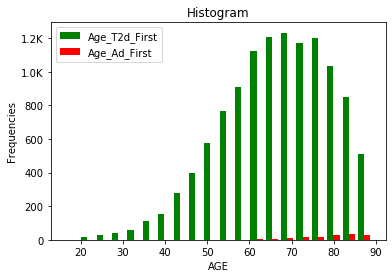

In [26]:
#histogram of age of T2D and age of AD in one graph

from pyspark_dist_explore import hist
fig, ax = plt.subplots()
hist(ax, df1_new_mimic, bins = 20, color=['green','red'])
ax.set_ylabel('Frequencies')
ax.set_xlabel('AGE')
ax.set_title('Histogram')
ax.legend(prop={'size': 10})

In [27]:
df2_new_mimic=df_mimic.select(['gender','Age_T2d_First', 'Age_Ad_First'])

([<matplotlib.axis.XTick at 0x23ad9177248>,
 <a list of 2 Text xticklabel objects>)

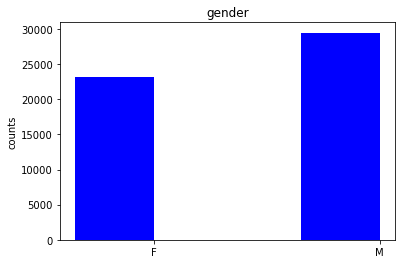

In [31]:
import numpy as np
responses = df2_new_mimic.groupBy('gender').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='b')

plt.ylabel('counts')
plt.title('gender')
plt.xticks(ind + width/2., categories)

In [32]:
df3_mimic=df2_new_mimic.filter(df2_new_mimic.Age_T2d_First.isNotNull() & df2_new_mimic.Age_Ad_First.isNotNull())

In [33]:
df3_mimic.show(5)

+------+-------------+------------+
|gender|Age_T2d_First|Age_Ad_First|
+------+-------------+------------+
|     F|        65.99|      66.488|
|     F|        65.99|      66.488|
|     M|       72.232|      72.232|
|     F|       88.919|      88.919|
|     M|       78.748|      78.748|
+------+-------------+------------+
only showing top 5 rows



([<matplotlib.axis.XTick at 0x23ad9111888>,
 <a list of 2 Text xticklabel objects>)

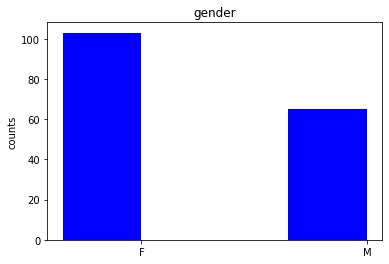

In [34]:
import numpy as np
responses = df3_mimic.groupBy('gender').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='b')

plt.ylabel('counts')
plt.title('gender')
plt.xticks(ind + width/2., categories)

# the analysis of this table with respect to gender and T2D age , AD age

In [35]:
#T2D_age_total count
T2D_age_total=df2_new_mimic.filter(df2_new_mimic.Age_T2d_First. isNotNull()).count()
T2D_age_total

12184

In [36]:
#count T2D_age_total by gender
T2D_age_total_byGender=df2_new_mimic.filter(df2_new_mimic.Age_T2d_First. isNotNull()).groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F| 5228|
|     M| 6956|
+------+-----+



In [37]:
#AD_age_total count
AD_age_total=df2_new_mimic.filter(df2_new_mimic.Age_Ad_First. isNotNull()).count()
AD_age_total

600

In [38]:
#count AD_age_total by gender
AD_age_total_byGender=df2_new_mimic.filter(df2_new_mimic.Age_Ad_First. isNotNull()).groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  348|
|     M|  252|
+------+-----+



In [39]:
df2_mimic=df1_mimic.filter(df1_mimic.Age_T2d_First.isNotNull() & df1_mimic.Age_Ad_First.isNotNull())

In [40]:
df2_mimic.show(10)

+---------+------+-------------+------------+---------------+
|person_id|gender|Age_T2d_First|Age_Ad_First|T2D_OR_AD_FIRST|
+---------+------+-------------+------------+---------------+
|    23706|     F|        65.99|      66.488|         -0.497|
|    23706|     F|        65.99|      66.488|         -0.497|
|     6597|     M|       72.232|      72.232|            0.0|
|    64798|     F|       88.919|      88.919|            0.0|
|    79229|     M|       78.748|      78.748|            0.0|
|    45684|     F|       69.736|      69.736|            0.0|
|     7169|     F|       85.743|      85.743|            0.0|
|      876|     F|       87.353|      87.353|            0.0|
|    11059|     F|       84.062|      84.062|            0.0|
|    43738|     F|       72.994|      72.994|            0.0|
+---------+------+-------------+------------+---------------+
only showing top 10 rows



# histogram of age of T2D and age of AD 

In [46]:
df2_mimic_new=df2_mimic.select(['Age_T2d_First', 'Age_Ad_First']).filter(df_mimic.Age_T2d_First<=100 )

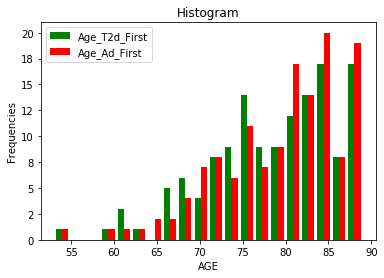

In [47]:
#histogram of age of T2D and age of AD in one graph

from pyspark_dist_explore import hist
fig, ax = plt.subplots()
hist(ax, df2_mimic_new, bins = 20, color=['green','red'])
ax.set_ylabel('Frequencies')
ax.set_xlabel('AGE')
ax.set_title('Histogram')
ax.legend(prop={'size': 10})

In [48]:
df2_mimic.show(10)

+---------+------+-------------+------------+---------------+
|person_id|gender|Age_T2d_First|Age_Ad_First|T2D_OR_AD_FIRST|
+---------+------+-------------+------------+---------------+
|    23706|     F|        65.99|      66.488|         -0.497|
|    23706|     F|        65.99|      66.488|         -0.497|
|     6597|     M|       72.232|      72.232|            0.0|
|    64798|     F|       88.919|      88.919|            0.0|
|    79229|     M|       78.748|      78.748|            0.0|
|    45684|     F|       69.736|      69.736|            0.0|
|     7169|     F|       85.743|      85.743|            0.0|
|      876|     F|       87.353|      87.353|            0.0|
|    11059|     F|       84.062|      84.062|            0.0|
|    43738|     F|       72.994|      72.994|            0.0|
+---------+------+-------------+------------+---------------+
only showing top 10 rows



In [55]:
#Total person having T2D or AD 
df2_mimic.count()

168

In [56]:
#Total person having T2D or AD by gender
df2_mimic.groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  103|
|     M|   65|
+------+-----+



In [49]:
#T2D first Diag
df2_mimic.filter(F.col("T2D_OR_AD_FIRST") < 0).count()

36

In [50]:
#AD first Diag
df2_mimic.filter(F.col("T2D_OR_AD_FIRST") > 0).count()

4

In [51]:
#T2D and AD at the same time
df2_mimic.filter(F.col("T2D_OR_AD_FIRST") == 0).count()

128